# Tornados? In Michigan? Today...?

Thats right! Today is a big severe weather day (for Michigan, anyway) and we are going to have a look at some of the ways that meteorologists use Python to analyse it.

Understanding a severe weather day is super complex, and often requires the analysis of lots of rapidly changing parameters. It is a mixture of math, physics, computer science, social science and data science (to name a few), but you can always guarantee that you will see two things: big data and maps.

So, today, we are going to do a whistlestop tour of some of the ways we can understand today's severe weather risk, and when you walk out of this talk, you will see it unfold right before your eyes (maybe... Forecasting is hard...)

## 1. Boring Stuff (imports)

First things first, lets deal with the boring stuff so we can get this analysis underway. We will need to use some open source packages to visualise the data we are working with. We need to set up an anaconda environment with the necessary packages.


In [ ]:
#########################
#       Python Tip!     #
#########################
#Use a package manager like Anaconda for each of your projects so that you can be sure that all of your packages are compatible with each other. 
#The more you use python, the more you will use open source packages which are updated and maintained differently. 
#Installing them all together will prevent you from updating one thing, but not another, and causing confusing problems!

%conda create -n tornadoAnalysis numpy xarray matplotlib siphon cartopy metpy pandas geopandas scipy

In [9]:
#########################
#       Python Tip!     #
#########################
# Put all your imports at the start of your code, even if you will only use them later. 
# It is really helpful for organisation, and lets you see what might be missing later on!

# actually import our packages
# base package imports
from datetime import datetime           # we will use this to parse strings representing dates and times

# data processing imports
import xarray as xr                     # we will use this to read and store big data stored in NetCDF format
from xarray.backends import NetCDF4DataStore

import geopandas as gpd                 # we will use this to read and store data stored in shapefile format
from siphon.catalog import TDSCatalog   # we will use this to download meteorological data from the internet straight into python!

# data analysis imports
import cartopy                          # we will use all the cartopy imports to create maps with our data
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
from matplotlib.patches import Patch    # this is just useful for formatting

import metpy.calc                       # we will use this to do some meteorological calculations
from metpy.units import units

%matplotlib inline

## 2. Storm Prediction Centre Outlooks

For most meteorologists, the Storm Prediction Centre (SPC) is the first port of call on a high impact weather day. The SPC issues a [convective outlook](https://www.spc.noaa.gov/products/outlook/day1otlk.html), which tells us what the chance of severe weather occuring across the USA on a given day. They also issue a breakdown of the risk of each of the three main high impact weather types (hail, wind and tornadoes), using a probability map.

We can plot these ourselves, and tune them in such a way that they are useful to us. If you are a TV or local forecast office meteorologist, you might want to zoom in on your local area to better communicate the risk to your community. If you are an emergency manager or first responder, you might want to see where your city lies relative to the risk area. If you are a researcher, or modeller, you might want to look and see if severe weather *did* occur in the area it was forecast.

The SPC makes their data available as shapefiles, which are a very common format of representing and storing data in all fields that use geographical information systems (GIS). You can get these from the [SPC website](https://www.spc.noaa.gov/gis/), but I have also included them here for you to save time.

You might remember from earlier that there are 5 levels of risk for severe weather:

0. General Thunderstorm
1. Marginal (isolated severe thunderstorms possible)
2. Slight (scattered severe thunderstorms possible)
3. Enhanced (numerous severe thunderstorms possible)
4. Moderate (widespread severe thunderstorms likely)
5. High (widespread severe thunderstorms expected)

Lets see what the risk is for today:

In [5]:
# First we need to read in our data as a shapefile

#########################
#       Python Tip!     #
#########################
# Always look at your data before you plot it. It is never what you expect!

outlook_filepath = '/Users/laratobias-tarsh/Downloads/day1otlk-shp/day2otlk-shp/day2otlk_cat.shp'     # replace this with the filepath on your computer
conv_oulook = gpd.read_file(outlook_filepath)   # use geopandas to read the shapefiles in

In [6]:
conv_oulook

,DN,VALID,EXPIRE,ISSUE,LABEL,LABEL2,stroke,fill,geometry
0,2,202307261200,202307271200,202307250600,TSTM,General Thunderstorms Risk,#55BB55,#C1E9C1,"POLYGON ((-99.87864 49.18514, -101.15000 47.81..."
1,3,202307261200,202307271200,202307250600,MRGL,Marginal Risk,#005500,#66A366,"MULTIPOLYGON (((-81.91047 43.66098, -89.51000 ..."
2,4,202307261200,202307271200,202307250600,SLGT,Slight Risk,#DDAA00,#FFE066,"POLYGON ((-82.24487 42.72831, -86.85000 42.430..."
3,5,202307261200,202307271200,202307250600,ENH,Enhanced Risk,#FF6600,#FFA366,"POLYGON ((-81.08613 42.45428, -82.73000 40.590..."


we can see here a table showing the data we have stored in these shapefiles. First of all, we see there are 4 rows, which means there are 4 layers in this shapefile, corresponding to the thunderstorm risk we are in.

Lets break down the useful columns and understand what we are working with:
1. 'DN': ignore this - we will not need to use it!
2. 'VALID': this is the time that the SPC convective outlook forecast is valid for
3. 'EXPIRE': this is the time the SPC convective outlook forecast expires
4. 'ISSUE': this is when the forecast was issued. We can ignore this.
5. 'LABEL': this is the label for each layer of the shapefile, corresponding to the storm risk.
6. 'LABEL2': fairly obvious
7. 'stroke': this is for formatting
8. 'fill': this is form formatting
9. 'geometry': this is our spatial data, containing coordinates, and the most important part.


We can look at geometry more:

In [7]:
# Look at the geometries for all of the data
conv_oulook.geometry

0    POLYGON ((-99.87864 49.18514, -101.15000 47.81...
1    MULTIPOLYGON (((-81.91047 43.66098, -89.51000 ...
2    POLYGON ((-82.24487 42.72831, -86.85000 42.430...
3    POLYGON ((-81.08613 42.45428, -82.73000 40.590...
Name: geometry, dtype: geometry

<Axes: >

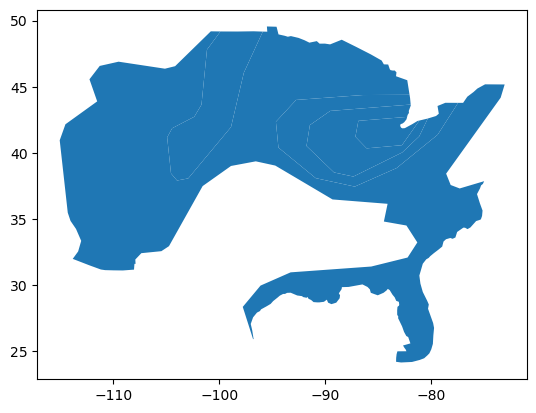

In [8]:
# Lets plot them to actually understand this. Geopandas has some nice inbuilt features for this!
conv_oulook.plot()

Okay... now we are getting somewhere. We can see there are 5 or so layers, and a tail which *kind of* looks like Florida? Maybe? We now have at least a slight idea of what we are working with, but we really can't say anything about the severe risk for today yet. 

Lets try and plot this on a map, and see what we are really working with. We are going to use a package called 'Cartopy' alongside our geopandas shapefile for this, which allows us to plot maps from all sorts of coordinate systems, a bit like we talked about before. Deep down, Cartopy is a wrapper for Python's main plotting library, Matplotlib, which you may have come across.

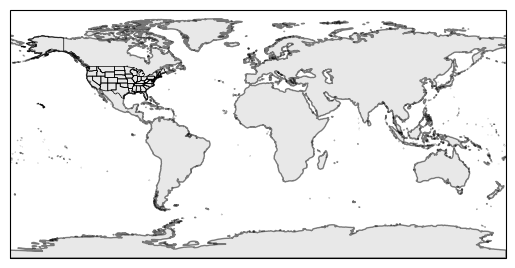

In [44]:
# Create a figure and axis using cartopy's PlateCarree projection.
# If you want, try playing with the other projections e.g. LambertConformal or Geodetic to see the differences
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add Natural Earth features built into cartopy so we can provide context to our map
land = NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor='lightgrey', alpha=0.5) # alpha sets the opacity of the plot
ax.add_feature(land, edgecolor='black', zorder=0)                                                           # zorder allows us to layer on top of plots!
ax.add_feature(cartopy.feature.STATES, edgecolor='k', linewidth=0.5, zorder=9)                              # zorder = 10 will force the states to the top, always

At last, we have a map we can add data to! We are going to use a for loop to go over each row in the table:

#### ASIDE: F Strings
In my opinion **most** helpful tool in python based data analysis is the f-string. These are normal strings, formatted in a readable, concise manner that make your life so much easier! They allow you to add variables to your strings, so that you can make your code customisable and clean, and prevent long, easy to misread and write strings.

An f-string is the same as a string, but it uses an *f* at the start, before you add your quotation marks, and curly braces for where you want to call a variable. For example:

```
>>> name = 'Lara'
>>> print(f'hello {name}')
'hello Lara'
```

We will use this to add titles to our plots here, and later to create clean filepaths that change depending on variable.

iterating over row: TSTM
iterating over row: MRGL
iterating over row: SLGT
iterating over row: ENH


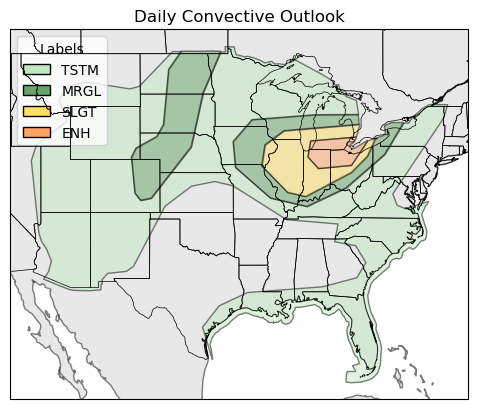

<Figure size 640x480 with 0 Axes>

In [45]:
# Loop through each label and plot the corresponding geometries with the specified colors
legend_handles = []  # Make an empty list to store handles for the legend

# lets loop over each row of the dataframe, get the storm risk and the color stored in the geopandas dataframe
for label, color in zip(conv_oulook['LABEL'].unique(), conv_oulook['fill'].unique()):
    # index in to the geopandas data and extract the risk category (LABEL)
    df_label = conv_oulook[conv_oulook['LABEL'] == label]
    
    print(f'iterating over row: {label}') # to help you understand what is going on! (plus f-strings!)
    #print(f'geometry: {df_label}\n')

    # plot the data on the map using the inbuilt geopandas functionality (like before), but make it look pretty!
    plot = df_label.plot(ax=ax, facecolor=color, edgecolor='black', label=label, zorder=2, alpha=0.5)

    # format the labels and add them to the empty list, so that we can add a nice legend
    legend_handles.append(Patch(facecolor=color, edgecolor='black', label=label))  # Store the legend patch for each label

# Set title and legend with custom handles
ax.set_title('Daily Convective Outlook')
ax.legend(handles=legend_handles, title='Labels', loc='upper left')
fig

Cool, but this is nothing we couldn't tell from the SPC website. How about we zoom in on the Midwest, and add some other cool features that help us interpret what we are seeing, and what this means for us!

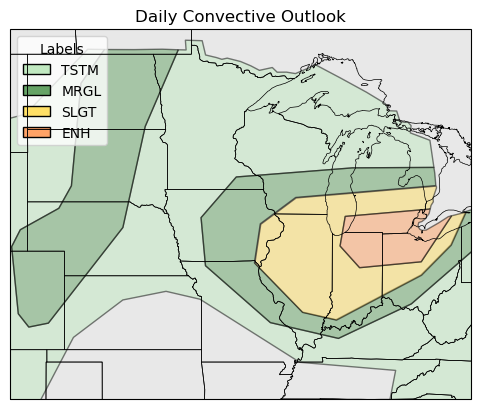

In [46]:
# zoom in on the midwest and plot Ann Arbor
extent = [-105, -80, 35, 50]  # [min_lon, max_lon, min_lat, max_lat]
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig

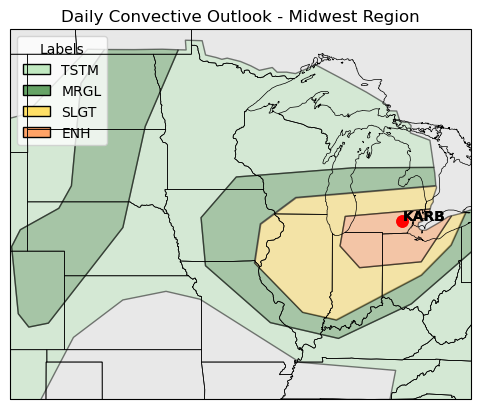

In [48]:
# Lets see where we are on the map. Why don't we plot a point on the map:

# Plot Ann Arbor Airport (KARB) and label it
airport_lon, airport_lat = -83.7463, 42.2258
ax.plot(airport_lon, airport_lat, marker='o', markersize=8, color='red', transform=ccrs.PlateCarree())
ax.text(airport_lon + 0.02, airport_lat + 0.02, 'KARB', color='k', transform=ccrs.PlateCarree(), fontsize=10, fontweight='bold')

# Set title and legend with custom handles
ax.set_title('Daily Convective Outlook - Midwest Region')
fig # type fig to view the figure

# Ex 1: Find the coordinates of your house/dorm/somewhere interesting to you, find the coordinates on google maps, 
#       and use the same approach to plot and label it on the outlook map! Edit the above code to produce it!

In [51]:
# Lets make this title better. Right now it isn't very descriptive...

time_str = conv_oulook.VALID.unique()[0] #index into the geopandas dataframe and extract the valid time
print(f'Forecast valid from: {time_str}')

Forecast valid from: 202307261200


This is not all that helpful, its just a string of numbers... This is where the datetime package comes in! It is a super helpful package from the python developers that allows us to nicely parse time into a format that is readable regardless of how it is presented. This might sound silly now, but if you ever do data science in the future, you will come across all sorts of ridiculous ways that people write time...

If we look hard enough, we can break it down:
2023 (year), 07 (month), 26 (day), 12 (hours), 00 (mins)

Note that the time zone here is UTC (Universal Time Coordinated - which avoids the confusion of multiple timezones). To convert to Eastern Time, subtract 5hrs.

We can use the datetime library to make this much easier to read. The codes are pretty much universal across all languages too, so it is a very helpful skill to learn. We will convert to Year-Month-Day Hour:Minute, but you could use any other format too. To see the different codes you can use when formatting times as a string, refer to [this lovely table.](https://www.w3schools.com/python/gloss_python_date_format_codes.asp)
 
 *and yes, meteorologists do use 24 hour time... sorry Americans :-)*

In [52]:

date_time_obj = datetime.strptime(time_str, "%Y%m%d%H%M")       # define the original format (no spaces, the % represents each different unit)
formatted_time_str = date_time_obj.strftime("%Y-%m-%d %H:%M")  # reformat the date time in a nicer way
print(f'Forecast valid from: {formatted_time_str}')

Forecast valid from: 2023-07-26 12:00


In [ ]:
# Ex 2: index into the shapefile again, extract the EXPIRE time like we did above, then use datetimes to reformat the string so they are readable.
#       Create an f-string in to title our plot, so that it reads:
#       "SPC Convective Outlook: VALID [extracted & formatted valid time] to [extracted & formatted expiry time]
#       remeber to type fig at the end of your code cell to see the updated figure

## 3. Forecast Breakdown

We have the SPC convective outlook. Cool. But this doesn't tell us all that much about the risk. I promised you all tornados... Well, good thing we know how to make pretty plots now, because the SPC gives us a risk breakdown of shapefiles too!

We can also learn another really useful skill in data visualisation here, too - making multiple plots. Sounds thrilling... I know. But, when you have lots of variables in your study data, or you need to show multiple related plots, this can be essential. This is how we use data to tell a story, rather than just dump information.

Luckily, Matplotlib and Cartopy make this really nice and easy for us, although it does have a couple of finicky elements. Lets have a look at how it works by making a 2 x 2 plot. For some reason (beyond the scope of the course, or any real relevancy), we need to use a datatype called a tuple to store each row of axes. There are lots of different ways to approach and circumvent this, but we will take the most simple, failsafe method, where we can access each axis by name.

This means we can access each axes for plotting like this:
```
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
ax1.plot(random_thing1, random_thing1)
ax2.plot(random_thing2,random_thing2)
ax3.set_title('random title')
```

We can do this with our shapefile data too:

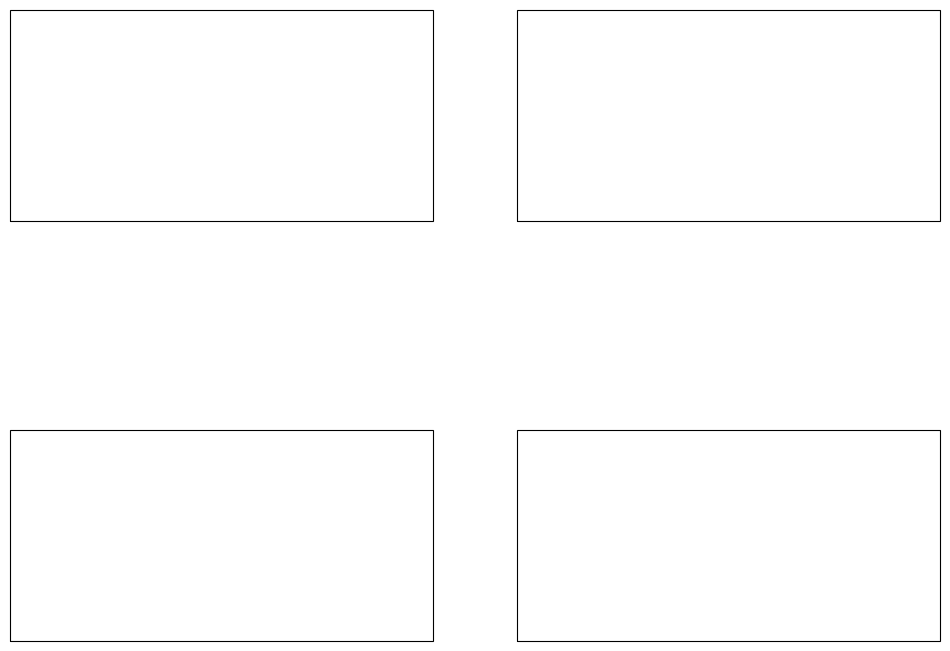

In [79]:
# We make our subplots using the same syntax as before, but this time we customise it a bit more. 
# Here we are going to make a 2 x 2 plot. The outer brackets hold all the axes, the inner brackets hold the axes in each row:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), 
                                             subplot_kw={'projection': ccrs.PlateCarree()}) # define a geographic projection - we are plotting on all of them



# keep our focus on the midwest!
extent = [-105, -80, 35, 50]  # [min_lon, max_lon, min_lat, max_lat]

# Ex. 3: scroll up in the code, and set the extent of each of the axes to zoom into the midwest. Each axes will need to be set seperately. 

Remember f-strings? Well, lets use them again to get the rest of our data in a nice, clean manner! We are going to define filepaths to the rest of the data, but instead of typing it out each time, we can take advantage of the directory structure to construct our filepaths.

Lets read in the tornado, hail and wind risk polygons using geopandas:

In [80]:
# define the variable you want from "cat" (convective outlook), "torn" (tornado), "wind", or "hail"
var = "cat"
filepath = f'/Users/laratobias-tarsh/Downloads/day1otlk-shp/day2otlk-shp/day2otlk_{var}.shp'
# now we use a generic name
df = gpd.read_file(filepath)

df

,DN,VALID,EXPIRE,ISSUE,LABEL,LABEL2,stroke,fill,geometry
0,2,202307261200,202307271200,202307250600,TSTM,General Thunderstorms Risk,#55BB55,#C1E9C1,"POLYGON ((-99.87864 49.18514, -101.15000 47.81..."
1,3,202307261200,202307271200,202307250600,MRGL,Marginal Risk,#005500,#66A366,"MULTIPOLYGON (((-81.91047 43.66098, -89.51000 ..."
2,4,202307261200,202307271200,202307250600,SLGT,Slight Risk,#DDAA00,#FFE066,"POLYGON ((-82.24487 42.72831, -86.85000 42.430..."
3,5,202307261200,202307271200,202307250600,ENH,Enhanced Risk,#FF6600,#FFA366,"POLYGON ((-81.08613 42.45428, -82.73000 40.590..."


Recognise this? Its the same as the convective outlook from before. Now try changing it to another one of the variables and seeing what changes for each variable. Great! Now we have a much more flexible data structure, which allows us to change our plot based on a single input!

But, we still have to plot everything individually right? How annoying... Is there not a way we can make this even easier? 
(Spoiler, call your best friend, the for loop)

But first, lets use this to get our convective outlook back on the subplots:

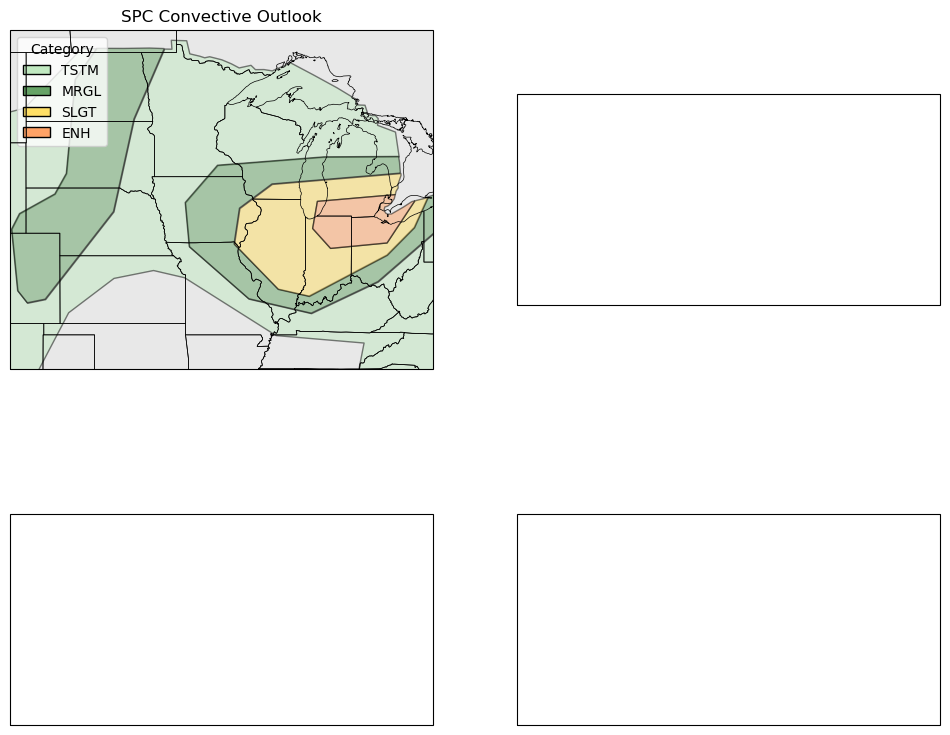

<Figure size 640x480 with 0 Axes>

In [81]:
# be sure to change your variable back to "cat" before running this cell!

land = NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor='lightgrey', alpha=0.5) # alpha sets the opacity of the plot
ax1.add_feature(land, edgecolor='black', zorder=0)                                                           # zorder allows us to layer on top of plots!
ax1.add_feature(cartopy.feature.STATES, edgecolor='k', linewidth=0.5, zorder=9)                              # zorder = 10 will force the states to the top, always

# Loop through each label and plot the corresponding geometries with the specified colors
legend_handles = []  # To store handles for the legend
ax1.set_extent(extent, ccrs.PlateCarree())
for label, color in zip(df['LABEL'].unique(), df['fill'].unique()):
    df_label = df[df['LABEL'] == label]
    plot = df_label.plot(ax=ax1, facecolor=color, edgecolor='black', label=label, zorder=2, alpha=0.5)
    legend_handles.append(Patch(facecolor=color, edgecolor='black', label=label))  # Store the legend patch for each label

# Set title and legend with custom handles
ax1.set_title('SPC Convective Outlook')
ax1.legend(handles=legend_handles, title='Category', loc='upper left')
fig

In [83]:
# Ex 4: Loop over all the variables and plot each analysis on its own individual axis. Use the code from before, and edit it slightly.
#       You really shouldn't have to change much!

# List your axes
axes_list = [ax1,ax2,ax3,ax4]
# list your variables
var_list = ["cat","torn","wind","hail"]

# iterate over the axes and variables at the same time
for axis,var in zip(axes_list,var_list):
    # define filepath
    # read filepath into df
    
    # use the code from before to add the land and states

    # use the code from before Loop through each label and plot the corresponding geometries with the specified colors
    
    # use the code from before to zoom in on the midwest

    # use the code from before to plot Ann Arbor Airport (KARB)
    
    # Set title and legend with custom handles. Write an if statemet to decide the title
    if var == "cat":
        title = "Convective Outlook"
    # if hail
    # if wind
    # if tornado
    axis.set_title(title)
    axis.legend(handles=legend_handles, loc='upper left')

# format the whole figure
fig.suptitle(f'SPC Severe Weather Risk: valid {formatted_time_str} UTC') # title the entire figure
fig.tight_layout() # nice way to make plots look pretty!

<Figure size 640x480 with 0 Axes>

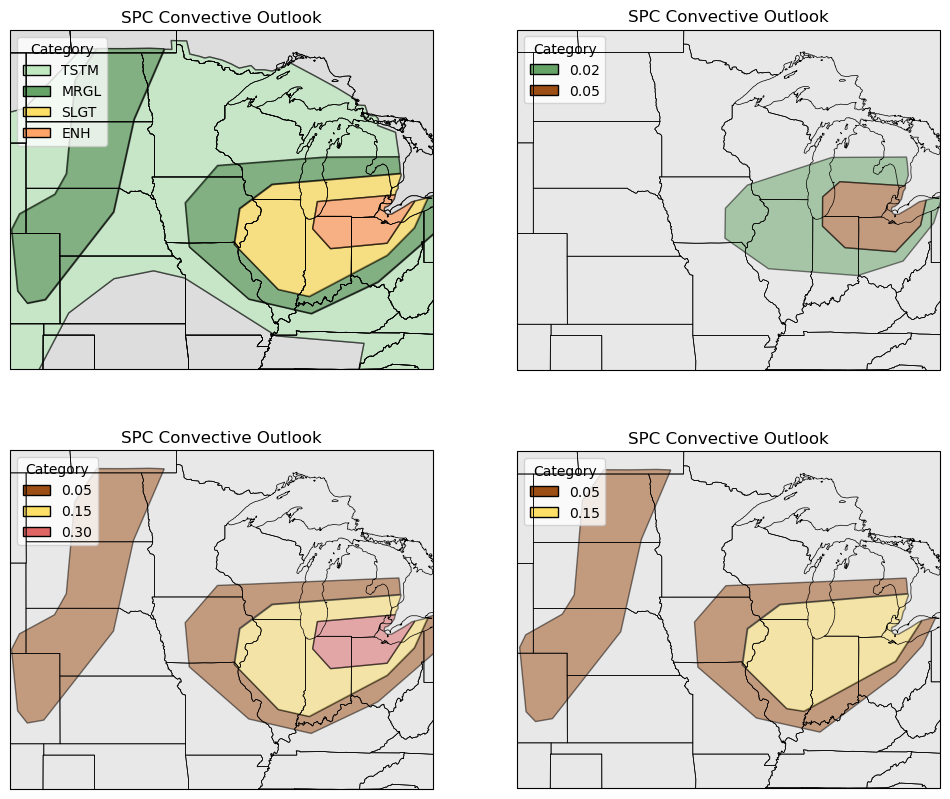

In [84]:
fig

So now we see, today there is a legitimate risk of severe weather, including tornados. Good thing we are all weather aware! Be sure to check your phones and keep an eye out for emergency alerts, as Ann Arbor is - as the storm chasing community says - "under the gun"...

## 4. But... Tornados don't happen in Michigan. Meteorologists are always wrong!

Aside from making me cry, this is a dangerous misconception. Don't believe me? I'll prove it to you! Lets go back to the SPC's huge archive of awesome data, and pull up some historical data (commonly called a climatology). 

This also lets us explore another method meteorologists use to store data, the NetCDF. This format is probably the most common in the industry, as it allows us to store huge amounts of data with multiple dimensions in a well compressed format. Because our forecast models cover billions of grid points, often with hundreds of different parameters and tens of timesteps, these files can get **really** big. I think the largest NetCDF I have worked with was 8 TB.


The SPC keeps a tornado climatology in NetCDF form on their website, but again, I have provided it for everyone. We will use a library specially developed for reading multidimensional data like our NetCDF called XArray to read it in. This library is the holy grail of natural science data analysis, and it is increasingly creeping into the world of financial trading and social science too. Its a really great one to be familiar with!


In [87]:
tornado_data = xr.open_dataset('/Users/laratobias-tarsh/Downloads/day1otlk-shp/day2otlk-shp/alltorn.nc')
tornado_data
# click on the data to see what is inside!

<xarray.Dataset>
Dimensions:  (lons: 45, lats: 70, x: 45, y: 70)
Coordinates:
    lon      (x, y) float64 ...
    lat      (x, y) float64 ...
Dimensions without coordinates: lons, lats, x, y
Data variables:
    alltorn  (lons, lats) float64 ...
Attributes:
    map_proj:     +proj=lcc +lat_0=25 +lon_0=265 +lat_1=25 +lat_2=25 +x_0=0 +...
    description:  Mean Number of Tornado Days per Year within 25 Miles of a P...

Lets inspect the data a little more. We can see from the Attributes that it contains data for the "Mean Number of Tornado Days per Year within 25 Miles of a Point between 1986 and 2015". 

It has lon (longitude) and lat (latitude) coordinates, as well as the data variable "alltorn". 

We can extract these for plotting and further investigation:

In [90]:
# Get the longitude, latitude, and data arrays from the xarray dataset
lons = tornado_data['lon']
lons

<xarray.DataArray 'lon' (x: 45, y: 70)>
[3150 values with dtype=float64]
Coordinates:
    lon      (x, y) float64 ...
    lat      (x, y) float64 ...
Dimensions without coordinates: x, y

In [91]:
lats = tornado_data['lat']
lats

<xarray.DataArray 'lat' (x: 45, y: 70)>
[3150 values with dtype=float64]
Coordinates:
    lon      (x, y) float64 ...
    lat      (x, y) float64 ...
Dimensions without coordinates: x, y

In [94]:
data = tornado_data['alltorn']
data
# notice how data has lons and lats. This tells us that this is our geographically indexed data, a.k.a. we can plot this on a map!

<xarray.DataArray 'alltorn' (lons: 45, lats: 70)>
[3150 values with dtype=float64]
Dimensions without coordinates: lons, lats

In [97]:
data.values

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.33909847e-08, ...,
        8.50545848e-07, 9.95923326e-08, 6.38113313e-09],
       [0.00000000e+00, 0.00000000e+00, 3.05789325e-09, ...,
        7.01837288e-08, 8.23855959e-09, 5.30693273e-10],
       [0.00000000e+00, 0.00000000e+00, 2.65346636e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

We know how to make plots now, so lets see what this data really looks like!

Unlike when we used geopandas, our data is not natively a shapefile. Instead it has actual numerical values at each point. In this case, we are going to make a contour plot of tornado risk, but we will have to do some of the dirty work ourselves. Lets start with what we know, which is making a figure with cartopy:

In [ ]:
# Ex. 5: Set up a figure and a plot with a PlateCaree projection. 
#       Add the states, zoom into the midwest, and plot Ann Arbor Airport - just like before.
#       If you want, you can change the coordinates to see where your house would fall on the map!

# Now we can get down and dirty with matplotlib and cartopy!

# Lets make a countour plot
contourf = ax.contourf(lons, lats, data, levels=20, cmap='Set2', alpha=0.5)

# Lets add lines to the contour plot
contour = ax.contour(lons, lats, data, levels=20, colors='k', alpha=0.5)

# Add contour labels
clabels = plt.clabel(contour, inline=True, fontsize=10)

# Add colorbar and title
fig.colorbar(contourf, ax=ax,orientation='horizontal',pad=0.05,label='Mean Number of Tornado Days')
ax.set_title('Annual Average Days with Tornados Occuring within 25 miles of a Given Point (1986-2015)')
fig.tight_layout()


Okay, so a fairly small number. But still, this is not 0. Better safe than sorry right?

This is also history, it doesn't tell us much about today. Meteorologists have lots of different forecast metrics they can use to understand what the chance of a tornado happening on a specific day might be. One of these is "Total Totals", which is used to assess potential storm strength. It uses the difference in lapse rates (the rate temperature changes with height) between two atmospheric levels and the moisture just above the surface to quantify how likely storms are to develop. 

For most people, this is boring technical jargon and a silly name, so if you want to understand the meteorology a bit better (its super cool), come and talk to me! We can watch [videos of tornado](https://www.youtube.com/watch?v=lZlXJ75NzBM) to get into the nitty gritty, but ultimately this metric was developed because its easy to understand. The following table shows what the total totals index means:


| Value | Description |
| --- | ----------- |
| > 43 | Thunderstorms Unlikely |
| 44 to 45 | Isolated Moderate Thunderstorms |
| 46 to 47 | Scattered Moderate, Few Heavy Thunderstorms |
| 48 to 49 | Scattered Moderate, Few Heavy, Isolated Severe Thunderstorms |
| 50 to 51 | Scattered Heavy, Few Severe Thunderstorms, Isolated Tornadoes |
| 52 to 55 | Scattered to Numerous Heavy, Few to Scattered Severe Thunderstorms, Isolated Tornadoes |
| Greater Than 55 | Numerous Heavy, Scattered Severe Thunderstorms, Few to Scattered Tornadoes |


Like all metrics, this is designed to analyse model data, so it is only as good as the data we give it. However, it is generally a good metric of the risk at any given point.

This is also where all the data analysis gets really fun! We are going to pull real model data, used by meteorologists, in real time from the NOAA API, then use government maintained python packages for meteorology called 'MetPy and Siphon" to calculate the total totals index for the Midwest. This is legitimately something that forecasters at the weather service in Detroit are doing right now!

If this interests you, Unidata (who maintain these packages) have really great internship opportunities for college students (including freshmen) to help development!

In [98]:
# get the link to the most recent, clean GFS runs (main American model)
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
best_ds = list(best_gfs.datasets.values())[0] # get the most recent timestep
# Query the API
ncss = best_ds.subset()
query = ncss.query()
ncss.variables

# set the extent of the data (its very big so we only want to pull a small subset)
extent = [-105, -80, 35, 50]  # [min_lon, max_lon, min_lat, max_lat]
query.lonlat_box(north=50, south=35, east=(360-80), west=(360-105)).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Temperature_isobaric','Relative_humidity_isobaric') # take the variables we need
data = ncss.get_data(query)

# wait, this looks familiar...
data = xr.open_dataset(NetCDF4DataStore(data))
data

<xarray.Dataset>
Dimensions:                          (time: 1, latitude: 61, isobaric: 41,
                                      longitude: 101)
Coordinates:
    reftime                          (time) datetime64[ns] ...
  * latitude                         (latitude) float32 50.0 49.75 ... 35.0
  * time                             (time) datetime64[ns] 2023-07-26
  * isobaric                         (isobaric) float64 1.0 2.0 ... 1e+05
  * longitude                        (longitude) float32 255.0 255.2 ... 280.0
Data variables:
    Relative_humidity_isobaric       (time, isobaric, latitude, longitude) float32 ...
    Temperature_isobaric             (time, isobaric, latitude, longitude) float32 ...
    LatLon_721X1440-0p13S-180p00E-2  int32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

Gross. So many variables. Horrible variable names. This is real meteorology! 

Fortunately, most of this is junk, and we don't need it. Lets take some subsets of this NetCDF to clean up:

In [101]:
rh = data.Relative_humidity_isobaric
rh

<xarray.DataArray 'Relative_humidity_isobaric' (time: 1, isobaric: 41,
                                                latitude: 61, longitude: 101)>
[252601 values with dtype=float32]
Coordinates:
    reftime    (time) datetime64[ns] ...
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 35.5 35.25 35.0
  * time       (time) datetime64[ns] 2023-07-26
  * isobaric   (isobaric) float64 1.0 2.0 4.0 7.0 ... 9.5e+04 9.75e+04 1e+05
  * longitude  (longitude) float32 255.0 255.2 255.5 255.8 ... 279.5 279.8 280.0
Attributes:
    long_name:                       Relative humidity @ Isobaric surface
    units:                           %
    Grib_Variable_Id:                VAR_7-0--1-1_L100
    Grib2_Parameter:                 [0 1 1]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Moisture
    Grib2_Parameter_Name:            Relative humidity
    Grib2_Level_Type:                100
    Grib2_Level_Desc:                Isobaric surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1
    grid_mapping:                    LatLon_721X1440-0p13S-180p00E-2

In [102]:
temp = data.Temperature_isobaric
temp

<xarray.DataArray 'Temperature_isobaric' (time: 1, isobaric: 41, latitude: 61,
                                          longitude: 101)>
[252601 values with dtype=float32]
Coordinates:
    reftime    (time) datetime64[ns] ...
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 35.5 35.25 35.0
  * time       (time) datetime64[ns] 2023-07-26
  * isobaric   (isobaric) float64 1.0 2.0 4.0 7.0 ... 9.5e+04 9.75e+04 1e+05
  * longitude  (longitude) float32 255.0 255.2 255.5 255.8 ... 279.5 279.8 280.0
Attributes:
    long_name:                       Temperature @ Isobaric surface
    units:                           K
    Grib_Variable_Id:                VAR_7-0--1-0_L100
    Grib2_Parameter:                 [0 0 0]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:            Temperature
    Grib2_Level_Type:                100
    Grib2_Level_Desc:                Isobaric surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1
    grid_mapping:                    LatLon_721X1440-0p13S-180p00E-2

Some quick notes: 
* Isobaric refers to pressure levels, which is what meteorologists use to measure height above the ground.
* reftime is irrelevant for our purposes
* dewpoint is the temperature you need to cool air to for it to condense into a cloud. No cloud? No thunderstorm. We will need to calculate this!


Fortunatley. This is all relatively easy, and built into MetPy. This also shows another great strength of xarray, which is that it allows us to do math on data at individual points and levels across an entire dataset, very quickly and with no for loops or other iteration. Super convienient, and super quick!

Lets use a neat python feature to see what we need for these calculations:

In [115]:
#########################
#       Python Tip!     #
#########################
# You can see the docstring of a function by using the "help" function in ipython. This is great for jupyter notebook analysis!
# This saves you from having to comb documentation, and is extra helpful for debugging!

help(metpy.calc.dewpoint_from_relative_humidity)
# do the same for metpy.calc.total_totals_index

Help on function dewpoint_from_relative_humidity in module metpy.calc:

dewpoint_from_relative_humidity(temperature, relative_humidity)
    Calculate the ambient dewpoint given air temperature and relative humidity.
    
    Parameters
    ----------
    temperature : `pint.Quantity`
        Air temperature
    
    relative_humidity : `pint.Quantity`
        Relative humidity expressed as a ratio in the range 0 < relative_humidity <= 1
    
    Returns
    -------
    `pint.Quantity`
        Dewpoint temperature
    
    Examples
    --------
    >>> from metpy.calc import dewpoint_from_relative_humidity
    >>> from metpy.units import units
    >>> dewpoint_from_relative_humidity(10 * units.degC, 50 * units.percent)
    <Quantity(0.0536760815, 'degree_Celsius')>
    
    .. versionchanged:: 1.0
       Renamed ``rh`` parameter to ``relative_humidity``
    
    See Also
    --------
    dewpoint, saturation_vapor_pressure



In [116]:
Td = metpy.calc.dewpoint_from_relative_humidity(temp, rh)       # calculate the dew point
tti = metpy.calc.total_totals_index(temp.isobaric , temp, Td)   # calcualte the total totals
tti

/Users/laratobias-tarsh/opt/anaconda3/envs/pythonDemo/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
/Users/laratobias-tarsh/opt/anaconda3/envs/pythonDemo/lib/python3.11/site-packages/metpy/calc/thermo.py:1397: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


Magnitude,[[[44.4023498535156 45.66400756835935 46.63641967773435 ... 47.81500854492185 48.32648315429685 48.55008544921873] [44.6198791503906 44.78058471679685 45.07742919921873 ... 47.39423217773435 47.4185852050781 47.5267395019531] [43.49039306640623 43.82965698242185 44.44513549804685 ... 46.1978820800781 46.12222900390623 46.1040100097656] ... [47.96600952148435 46.55802001953123 48.4867004394531 ... 44.07575073242185 44.24835815429685 44.47504272460935] [47.3304504394531 47.12674560546873 47.03204956054685 ... 44.71259155273435 44.48337402343748 44.95633544921873] [49.84183349609373 47.22702636718748 47.03815307617185 ... 45.60922851562498 45.57855834960935 46.22943725585935]]]
Units,kelvin


Sweet! Those look like numbers! Lets plot them on a contour plot!

In [ ]:
# Ex. 6: Set up a figure and a plot with a PlateCaree projection. 
#       Add the states, zoom into the midwest, and plot Ann Arbor Airport - just like before.
#       If you want, you can change the coordinates to see where your house would fall on the map!

# extract the lons and lats
lons = temp.longitude
lats = temp.latitude
data = tti.squeeze()
# Use the same code as before to make a contourf (filled contour plot) of the total totals.
# Change the colormap to 'gist_heat_r' (because its cooler)

# Add a colorbar
cbar = plt.colorbar(contourf, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Total Totals Index (TTI)')

# Set the title and show the plot
ax.set_title(f'Total Totals Index (TTI) valid for {data.time.values[0]}')

Lets go even deeper. Now that we have numerically indexed data, we can get an actual number for Ann Arbor. What is our total totals right now?

In [117]:
tti_karb = metpy.calc.total_totals_index(temp.isobaric,
                                    temp.sel(latitude=airport_lat, longitude=airport_lon,method='nearest'), 
                                    Td.sel(latitude=airport_lat, longitude=airport_lon,method='nearest'))


print(f'The Total Totals Index (TTI) at Ann Arbor airport is: {tti_karb.magnitude[0]}')

The Total Totals Index (TTI) at Ann Arbor airport is: 42.6645568847656


Wow! That was a lot! But now we are much more weather aware! Stay safe today, and keep an eye on the warnings, as you now know, theres a chance things get gnarly!


If you ever have any questions about meteorology, please let me know! I love meteorology and I am president of our chapter of the American Meteorological Society, and am always up to talk about python, meteorology at college, National Labs, the University of Michigan, research or any of the other things I talked about today! You can reach me at laratt@umich.edu .


I hope you enjoyed the demo!

## REFERENCES
* https://unidata.github.io/MetPy/latest/examples/plots/spc_convective_outlook.html
* https://forecast.weather.gov/glossary.php?word=Total-Totals+index#:~:text=The%20total%2Dtotals%20index%20is,minus%20temperature%20at%20500%20mb.
* https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.total_totals_index.html
* https://www.youtube.com/watch?v=qRi5G5alJYQ